In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
from scipy.stats.distributions import norm

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

### Normal Distribution

Recall the probability density function of the normal distribution:

$$
p(x|\mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} e ^{-(x - \mu)^2/(2\sigma^2)}.
$$

In other words, given some properties of the distribution, the mean $\mu$ and the standard deviation $\sigma$, the function above described the probability *density* as a function of parameter $x\in(-\infty, \infty)$.

So if we want to look at what this distribution looks like a function of $x$, we can just evaluate this function at a bunch of $x$ values and plot it.

In [22]:
def pdf(x, mu=10, sigma=2.):
    return 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(x - mu)**2/(2*sigma**2))

In [23]:
mu = 10.
sigma = 2.

xs = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)

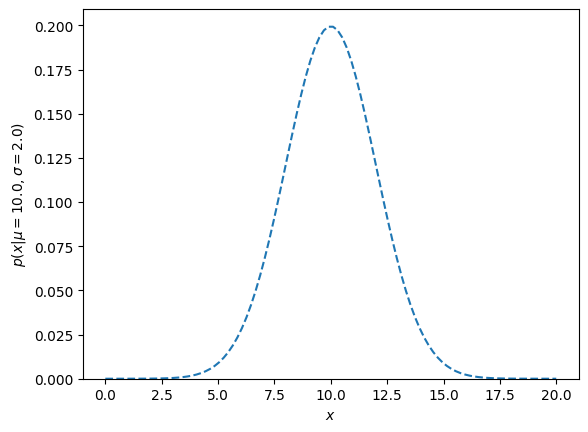

In [24]:
mu = 10.
sigma = 2.

xs = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)

plt.plot(xs, pdf(xs), ls='--')
plt.ylim(ymin=0)

plt.ylabel(r'$p(x|\mu={}, \sigma={})$'.format(mu, sigma))
plt.xlabel('$x$');

What if we didn't know the function form of the probability density function?  If we had a method of draws samples from the distribution, we can look at the distribution of those samples to get an idea of the shape of the probability density function.

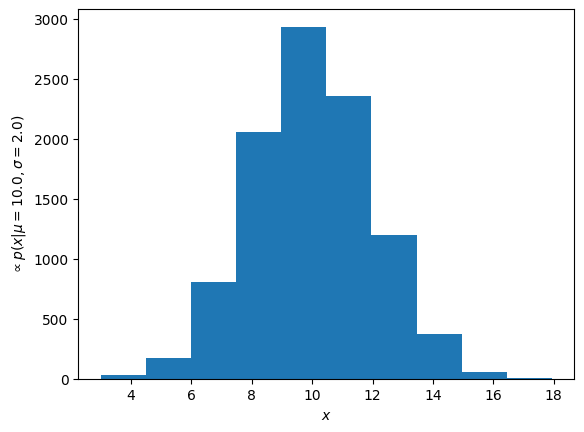

In [25]:
N = 10000

samples = norm.rvs(loc=mu, scale=sigma, size=N)
plt.hist(samples)

plt.ylabel(r'$\propto p(x|\mu={}, \sigma={})$'.format(mu, sigma))
plt.xlabel('$x$');

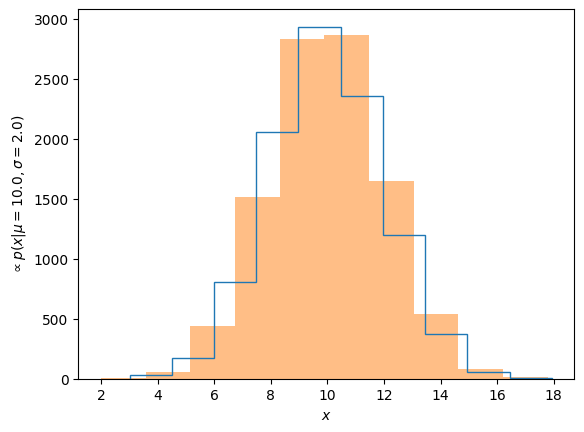

In [26]:
N = 10000

last_samples = samples
samples = norm.rvs(loc=mu, scale=sigma, size=N)
plt.hist(last_samples, histtype='step')
plt.hist(samples, alpha=0.5)

plt.ylabel(r'$\propto p(x|\mu={}, \sigma={})$'.format(mu, sigma))
plt.xlabel('$x$');

The more samples we have, the better we estimate the distribution.

In [27]:
def plot_dist(N=100, mu=10, sigma=5):
    xs = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)

    plt.plot(xs, norm.pdf(xs, loc=mu, scale=sigma))

    samples = norm.rvs(loc=mu, scale=sigma, size=N)
    plt.hist(samples, bins=30, alpha=0.5, density=True)

    plt.ylabel(r'$p(x|\mu={}, \sigma={})$'.format(mu, sigma))
    plt.xlabel('$x$')
    plt.ylim(0, .3)

In [28]:
interactive(plot_dist, N=(100, 10000), sigma=(1e-1, 10))

interactive(children=(IntSlider(value=100, description='N', max=10000, min=100), IntSlider(value=10, descripti…

# Monte Carlo Methods

Monte Carlo methods are a class of methods that use randomness to solve problems, typically for the purpose of optimization, numerical integration, and generating samples from a probability distribution.  The name comes from the fact that they were first used to solve problems in the Monte Carlo Casino in Monaco.

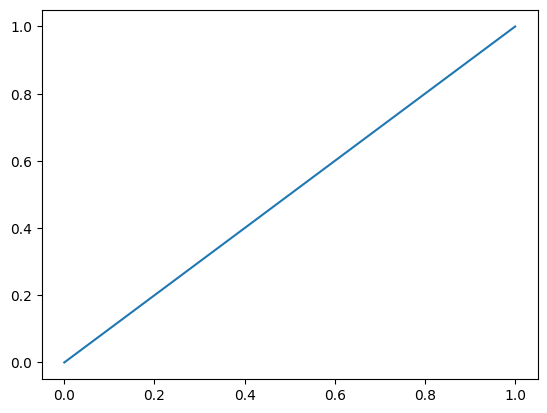

In [29]:
def Pr(w, n, p):
    norm = math.factorial(n) / (math.factorial(w) * math.factorial(n-w))
    return norm * p**w * (1-p)**(n-w)

obs = 'W'
w = obs.count('W')
n = len(obs)

ps = np.linspace(0, 1, 100)
plt.plot(ps, Pr(w, n, p=ps));

# Rejection Sampling

Now let's explore ways to generate samples from a distribution when we only know the functional form of its PDF.  Rejection sampling is one approach.

We'll refer to the target distribution that we want to draw samples from as $p(x)$. We can use another distribution $g(x)$ that we *can* draw samples from (whose PDF encompases the whole target distribution after rescaling by some value $k$) to draw samples from the target distribution.

We do so by drawing a sample $z$ from our sampling distribution.  We then generate a random number $u$ unifomly between 0 and $k*g(z)$.  If $u \leq p(z)$ the we save the sample.

In [30]:
import seaborn as sns

In [31]:
mu = 10
sigma = 2.

def p(x):
    '''The target distribution to draw samples from'''
    return pdf(x, mu=mu, sigma=sigma)

def g(x):
    '''A distribution we can draw samples from'''
    return np.ones_like(x)


x = np.linspace(-50, 50, 1000)
k = .4 #max(p(x) / g(x))

def rejection_sampling(iter=1000):
    samples = []

    for i in range(iter):
        z = np.random.uniform(-50, 50)
        u = np.random.uniform(0, k*g(z))

        if u <= p(z):
            samples.append(z)

    return np.array(samples)

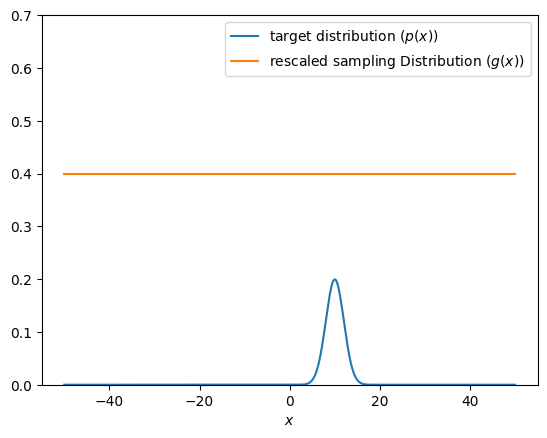

In [32]:
plt.plot(x, p(x), label='target distribution ($p(x)$)')
plt.plot(x, k*g(x), label='rescaled sampling Distribution ($g(x)$)')

plt.ylim(0, .7)
plt.legend()
plt.xlabel('$x$');

In [35]:
s = rejection_sampling(iter=100000)
print("{} samples drawn from target distribution".format(len(s)))

2403 samples drawn from target distribution


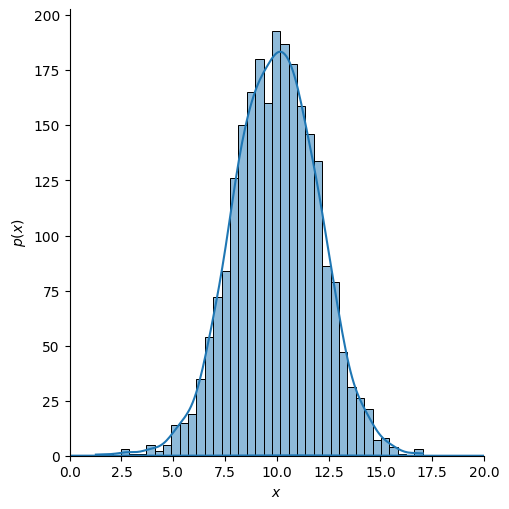

In [36]:
sns.displot(s, kde=True)
plt.plot(x, p(x))
plt.xlim(0, 20)
plt.xlabel('$x$')
plt.ylabel('$p(x)$');

Now let's sample a slightly more complex distribution.  We'll also switch to a normal sampling distribution.

In [37]:
def p(x):
    return .5*(pdf(x, mu=mu, sigma=sigma) + \
        pdf(x, mu=mu+5, sigma=sigma/2))

def g(x):
    return pdf(x, mu=mu, sigma=3*sigma)

def g_rvs():
    return norm.rvs(loc=mu, scale=3*sigma)

k = max(p(xs) / g(xs))

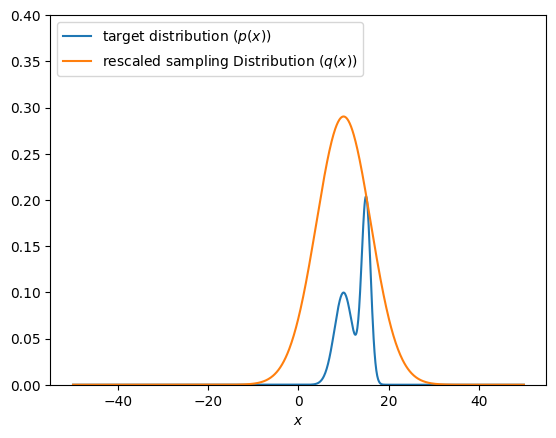

In [38]:
plt.plot(x, p(x), label='target distribution ($p(x)$)')
plt.plot(x, k*g(x), label='rescaled sampling Distribution ($q(x)$)')

plt.ylim(0, .4)
plt.legend(loc='upper left')
plt.xlabel('$x$');

In [39]:
def rejection_sampling(iter=1000):
    samples = []

    for i in range(iter):
        z = g_rvs()
        u = np.random.uniform(0, k*g(z))

        if u <= p(z):
            samples.append(z)
    return np.array(samples)

In [40]:
samps = rejection_sampling(iter=100000)

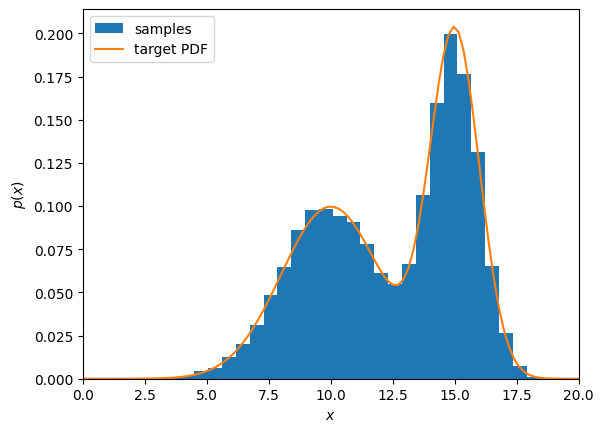

In [41]:
plt.hist(samps, bins=30, density=True, label='samples')
plt.plot(xs, p(xs), label='target PDF')
plt.legend()
plt.xlim(0, 20)
plt.xlabel('$x$')
plt.ylabel('$p(x)$');

# Importance Sampling

Let's say we are interested in estimating the expectation for some function of our parameter $h(\theta)$ after observing some data $y$, $\mathrm{E}(h(\theta)|y)$, but we can't draw random values of $\theta$ directly from $p(\theta|y)$, but we _can_ draw samples of $\theta$ from some other probability density function $g(\theta)$.

Since we often don't have a normalized posterior density function, we'll use the convention of $q(\theta|y)$ to refer to an unnormalized PDF, where $q(\theta|y) \propto p(\theta|y)$.  In this case:

$$
E(h(\theta)|y) = \int h(\theta) p(\theta|y)d\theta = \frac{\int h(\theta)q(\theta|y) d\theta}{\int q(\theta|y)d\theta}
$$

Putting in some factors of $1$...

$$
E(h(\theta)|y) = \frac{\int \left[ h(\theta)q(\theta|y)/g(\theta)\right] g(\theta)d\theta}{\int \left[q(\theta|y)/g(\theta)\right]g(\theta)d\theta}
$$

Which we can estimate with $S$ draws $\theta^1, \dots, \theta^S$ from $g(\theta)$

$$
E(h(\theta)|y) = \frac{\frac{1}{S}\sum_{s=1}^S h(\theta^s) w(\theta^s)}{\frac{1}{S}\sum_{s=1}^S w(\theta^s)}
$$

where

$$
w(\theta^s) = \frac{q(\theta^s|y)}{g(\theta^s)}
$$

are refered to as the _importance weights_.

Let's estimate the expactation value of $\theta$ (i.e., $h(\theta)=\theta$) from the last example we explored with rejection sampling.

In [42]:
def q(x):
    '''An unnormalized PDF'''
    return pdf(x, mu=mu, sigma=sigma) + \
        pdf(x, mu=mu+5, sigma=sigma/2)

# Define our sampling distribution g(x) as a random variable X_g
μ_g = mu
σ_g = 3 * sigma
X_g = norm(loc=μ_g, scale=σ_g)

In [43]:
S = 10000
x_gs = X_g.rvs(S)
ws = q(x_gs)/X_g.pdf(x_gs)

In [44]:
E_x = np.sum(x_gs * ws)/np.sum(ws)
print(E_x)

12.511766840276115


Let's compare that to the mean of the samples we drew using rejection sampling.

In [45]:
np.mean(samps)

np.float64(12.471992370880452)

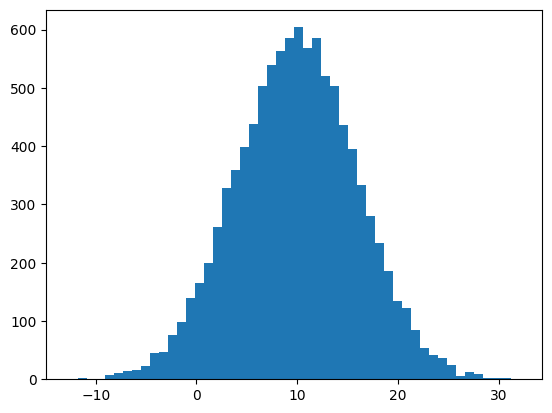

In [46]:
plt.hist(x_gs, bins=50);

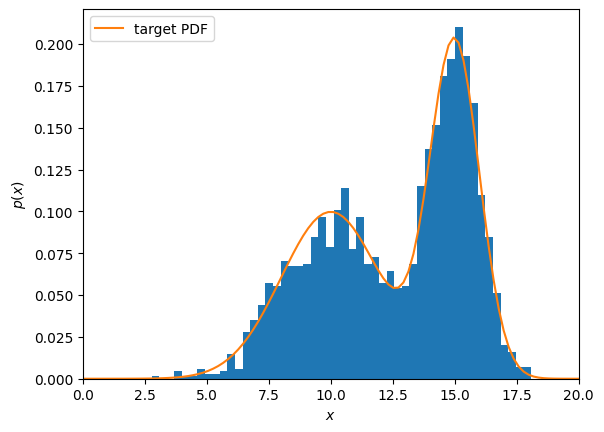

In [47]:
w_max = np.max(ws)
sel = np.random.uniform(0, w_max, S) < ws
plt.hist(x_gs[sel], bins=50, density=True);
plt.plot(xs, p(xs), label='target PDF')
plt.legend()
plt.xlim(0, 20)
plt.xlabel('$x$')
plt.ylabel('$p(x)$');

# Markov Chain Monte Carlo (MCMC)

# Metropolis algorithm

Here we're going to build a simple Metroplis sampler, and use it to draw samples from a target distribution.

The algorithm works in the following way:
1. The chain is at location $x$
1. A new location $x'$ is drawn from a proposal distribution $q(x)$, which we'll use $q(x)\sim \mathcal{N}(x, \sigma)$.
1. The ratio of the target probability density at the proposed location to the current location is calculated, $\alpha = \frac{p(x')}{p(x)}$.
1. If $\alpha>1$ the jump is accepted, if $\alpha<1$ it's accepted with a probability of $\alpha$.  If a jump is rejected the current sample $x$ is repeated in the chain.

In [49]:
x0 = -7.

x = x0
p_current = p(x0)

chain = [x]
probs = [p_current]

In [50]:
niter = 10000
sigma_jump = 5.

for i in range(niter):
    xp = norm.rvs(loc=x, scale=sigma_jump)
    p_p = p(xp)
    
    α = p_p/p_current
    u = np.random.uniform()
    accepted = u < α
    
    if accepted:
        x = xp
        p_current = p_p
    chain.append(x)
    probs.append(p_current)

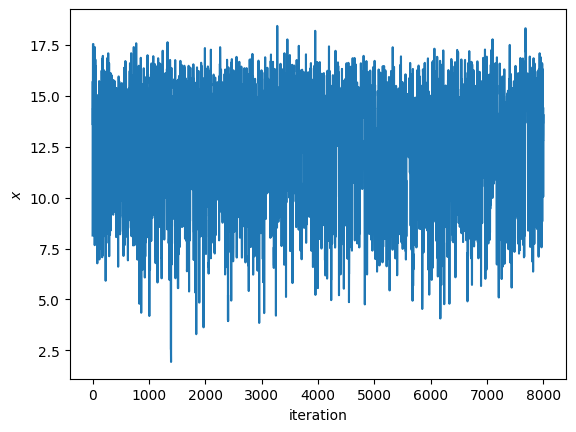

In [54]:
burnin_length = 2000

plt.plot(chain[burnin_length:])
plt.xlabel('iteration')
plt.ylabel('$x$');

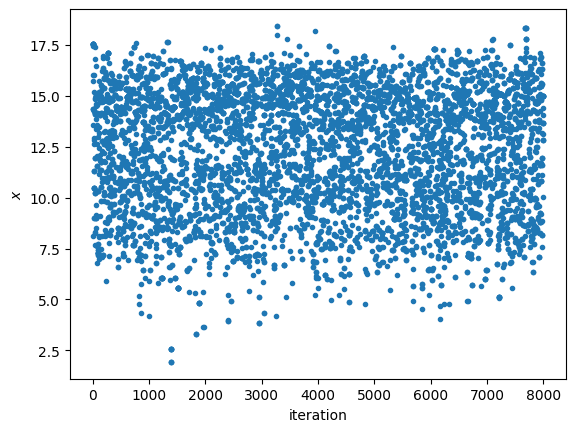

In [56]:
burnin_length = 2000

plt.plot(chain[burnin_length:],'.')
plt.xlabel('iteration')
plt.ylabel('$x$');

What's left looks like it's fairly uncorrelated, which is what we're looking for.  There are still correlations in the chain that, strictly speaking, should be dealt with (by thinning out the chain), but we'll call this good enough for our purprose, and take a look at the histogram, which gives us an idea of target distribution.

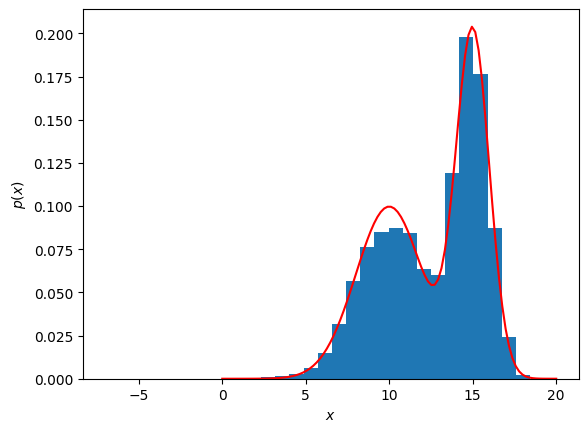

In [57]:
plt.hist(chain, density=True, bins=30, label='chain')
plt.plot(xs, p(xs), color='r', label='target PDF')
plt.xlabel('$x$')
plt.ylabel('$p(x)$');